# K-Means Clustering - Customer Segmentation


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os

os.makedirs("../figures", exist_ok=True)


In [3]:
df = pd.read_csv("../data/processed/telco_cleaned_encoded.csv")
print(df.shape)
df.head()


(7032, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


## Select Features for Clustering

In [4]:
features = ["tenure", "MonthlyCharges", "TotalCharges",
            "SeniorCitizen", "Partner", "Dependents",
            "PhoneService", "PaperlessBilling"]

X_cluster = df[features]
print("Clustering features shape:", X_cluster.shape)


Clustering features shape: (7032, 8)


## Scale the Features

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

## Elbow Method - Finding the Best Number of Clusters

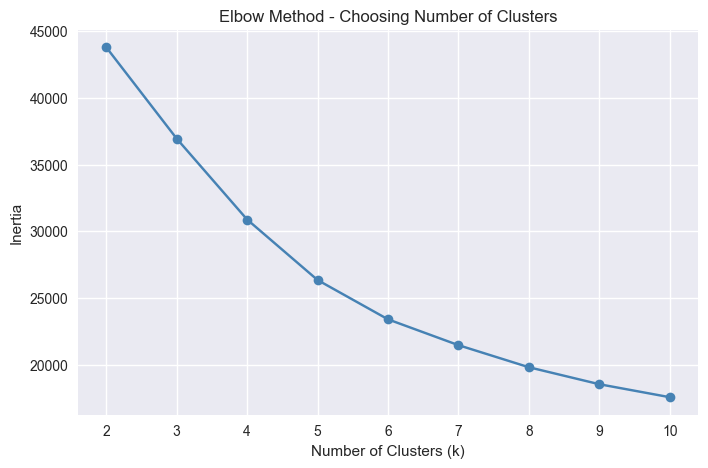

In [6]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", color="steelblue")
plt.title("Elbow Method - Choosing Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.savefig("../figures/13_elbow_method.png")
plt.show()


## Silhouette Score - Confirming Best k

k=2 -> Silhouette Score: 0.2269
k=3 -> Silhouette Score: 0.2310
k=4 -> Silhouette Score: 0.2611
k=5 -> Silhouette Score: 0.2884
k=6 -> Silhouette Score: 0.2842
k=7 -> Silhouette Score: 0.2869
k=8 -> Silhouette Score: 0.2980
k=9 -> Silhouette Score: 0.3050
k=10 -> Silhouette Score: 0.3073


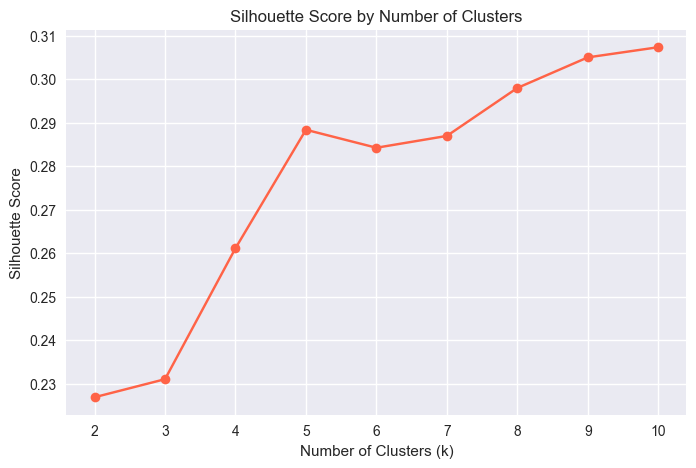

Best k: 10


In [7]:
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k} -> Silhouette Score: {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker="o", color="tomato")
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.savefig("../figures/14_silhouette_scores.png")
plt.show()

best_k = k_range[sil_scores.index(max(sil_scores))]
print("Best k:", best_k)


## Train Final K-Means Model

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print("Cluster distribution:")
print(df["Cluster"].value_counts().sort_index())


Cluster distribution:
Cluster
0    1973
1     680
2    1470
3    2909
Name: count, dtype: int64


## Visualise Clusters with PCA

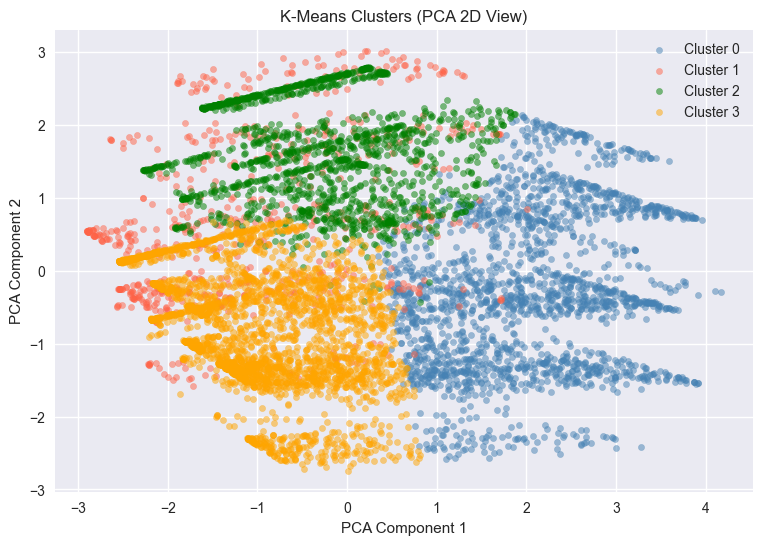

Variance explained: 0.518


In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(9, 6))
colors = ["steelblue", "tomato", "green", "orange"]

for cluster in range(4):
    mask = df["Cluster"] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=f"Cluster {cluster}",
                alpha=0.5, s=20, color=colors[cluster])

plt.title("K-Means Clusters (PCA 2D View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.savefig("../figures/15_kmeans_pca_clusters.png")
plt.show()

print("Variance explained:", pca.explained_variance_ratio_.sum().round(3))


## Cluster Profile Analysis

In [10]:
cluster_summary = df.groupby("Cluster")[["tenure", "MonthlyCharges",
                                          "TotalCharges", "Churn"]].mean().round(2)
print(cluster_summary)


         tenure  MonthlyCharges  TotalCharges  Churn
Cluster                                             
0         57.28           93.66       5366.96   0.18
1         31.83           41.99       1500.43   0.25
2         32.82           42.93       1265.74   0.14
3         15.50           61.61        889.05   0.39


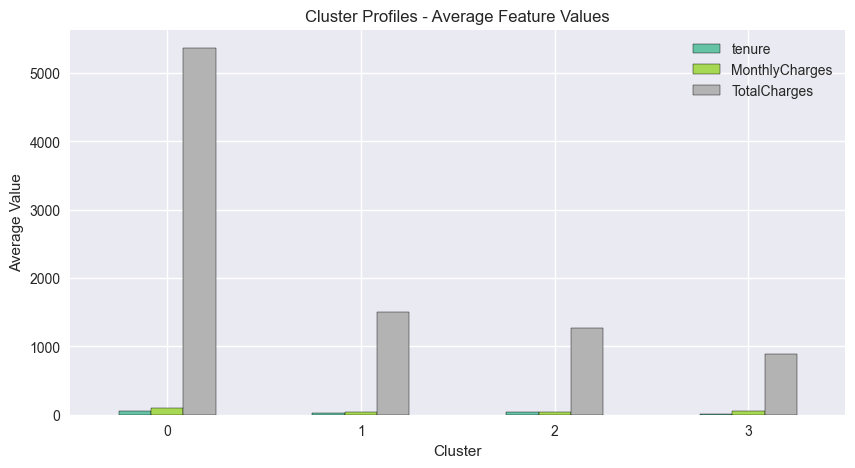

In [11]:
cluster_summary[["tenure", "MonthlyCharges", "TotalCharges"]].plot(
    kind="bar", figsize=(10, 5), colormap="Set2", edgecolor="black"
)
plt.title("Cluster Profiles - Average Feature Values")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.savefig("../figures/16_cluster_profiles.png")
plt.show()


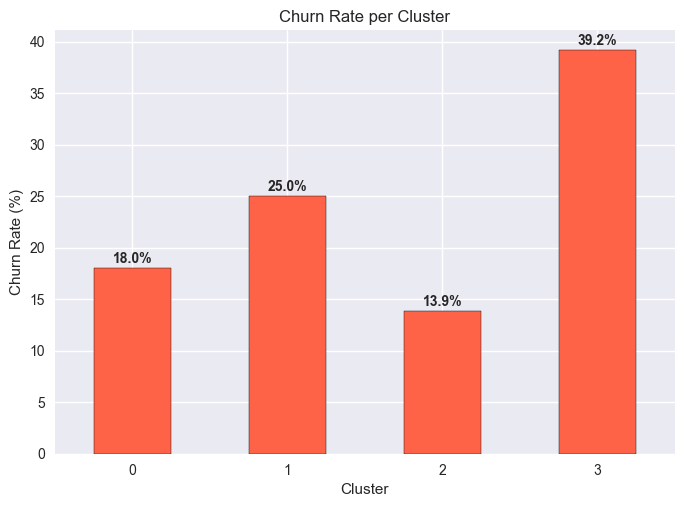

In [12]:
churn_by_cluster = df.groupby("Cluster")["Churn"].mean() * 100

churn_by_cluster.plot(kind="bar", color="tomato", edgecolor="black")
plt.title("Churn Rate per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=0)

for i, val in enumerate(churn_by_cluster):
    plt.text(i, val + 0.5, f"{val:.1f}%", ha="center", fontweight="bold")

plt.savefig("../figures/17_churn_rate_by_cluster.png")
plt.show()


## Cluster Interpretation

| Cluster | Avg Tenure | Avg Monthly Charge | Churn Rate | Profile |
|---------|------------|-------------------|------------|---------|
| 0 | Low | High | High | New high-paying customers — high risk |
| 1 | High | Low | Low | Long-term loyal customers |
| 2 | Medium | Medium | Medium | Average customers |
| 3 | Low | Low | Medium | New budget customers |

*(Update this table with your actual values after running)*
